<a href="https://colab.research.google.com/github/RKNahid/PMITProject242113/blob/main/Sleep_stage_13_12_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.signal import hilbert
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Project/REM_NREM.csv')
data.sample(5)

,Sleep_Stage,MeanP_Alpha_F4,MedianF_Alpha_F4,MeanF_Alpha_F4,Spectral Edge_Alpha_F4,PeakF_Alpha_F4,MeanP_Beta_F4,MedianF_Beta_F4,MeanF_Beta_F4,Spectral Edge_Beta_F4,...,MeanP_Delta_O2,MedianF_Delta_O2,MeanF_Delta_O2,Spectral Edge_Delta_O2,PeakF_Delta_O2,MeanP_Gamma_O2,MedianF_Gamma_O2,MeanF_Gamma_O2,Spectral Edge_Gamma_O2,PeakF_Gamma_O2
63566,NREM,0.00032,8.86634,14.98537,14.36098,10.98927,0.00025,13.73659,21.97854,22.85268,...,0.00091,1.62341,6.24390,3.62146,0.74927,0.000018,25.60000,35.71512,43.45756,49.95122
88678,NREM,0.00061,10.98927,19.35610,19.10634,11.11415,0.00103,19.73073,29.97073,32.96780,...,0.00115,1.12390,7.61756,4.24585,0.49951,0.000320,33.96683,39.96098,47.70341,38.08780
22575,REM,0.00042,9.36585,17.23317,16.35902,7.74244,0.00046,16.60878,24.72585,26.34927,...,0.00109,0.74927,6.49366,3.24683,0.49951,0.000077,49.82634,49.82634,50.07610,49.95122
41170,REM,0.00039,9.24098,16.35902,15.85951,6.61854,0.00036,16.10927,23.72683,24.85073,...,0.00097,0.99902,6.49366,3.24683,0.87415,0.000030,27.34829,35.71512,45.83024,49.95122
45527,REM,0.00024,8.11707,16.23415,14.73561,6.36878,0.00025,18.60683,32.84293,37.46341,...,0.00238,0.49951,6.36878,2.24780,0.24976,0.000033,33.59220,49.20195,49.95122,49.95122


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89096 entries, 0 to 89095
Data columns (total 76 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sleep_Stage             89096 non-null  object 
 1   MeanP_Alpha_F4          89096 non-null  float64
 2   MedianF_Alpha_F4        89096 non-null  float64
 3   MeanF_Alpha_F4          89096 non-null  float64
 4   Spectral Edge_Alpha_F4  89096 non-null  float64
 5   PeakF_Alpha_F4          89096 non-null  float64
 6   MeanP_Beta_F4           89096 non-null  float64
 7   MedianF_Beta_F4         89096 non-null  float64
 8   MeanF_Beta_F4           89096 non-null  float64
 9   Spectral Edge_Beta_F4   89096 non-null  float64
 10  PeakF_Beta_F4           89096 non-null  float64
 11  MeanP_Theta_F4          89096 non-null  float64
 12  MedianF_Theta_F4        89096 non-null  float64
 13  MeanF_Theta_F4          89096 non-null  float64
 14  Spectral Edge_Theta_F4  89096 non-null

In [5]:
data.isnull().sum()

,0
Sleep_Stage,0
MeanP_Alpha_F4,0
MedianF_Alpha_F4,0
MeanF_Alpha_F4,0
Spectral Edge_Alpha_F4,0
...,...
MeanP_Gamma_O2,0
MedianF_Gamma_O2,0
MeanF_Gamma_O2,0
Spectral Edge_Gamma_O2,0


In [6]:
numeric_data = data.select_dtypes(include=[np.number])

z_scores_numeric = numeric_data.apply(zscore)

outliers_z_numeric = (z_scores_numeric.abs() > 3).sum()

outliers_z_numeric[outliers_z_numeric > 0]

,0
MeanP_Alpha_F4,145
MedianF_Alpha_F4,1404
MeanF_Alpha_F4,1875
Spectral Edge_Alpha_F4,1953
PeakF_Alpha_F4,1163
...,...
MeanP_Gamma_O2,489
MedianF_Gamma_O2,1232
MeanF_Gamma_O2,1232
Spectral Edge_Gamma_O2,1233


In [7]:
rows_with_outliers = (z_scores_numeric.abs() > 3).any(axis=1)

# Count of rows before removal
rows_before = data.shape[0]

# Remove rows with outliers
cleaned_data = data[~rows_with_outliers]

# Count of rows after removal
rows_after = cleaned_data.shape[0]

rows_before, rows_after

(89096, 82163)

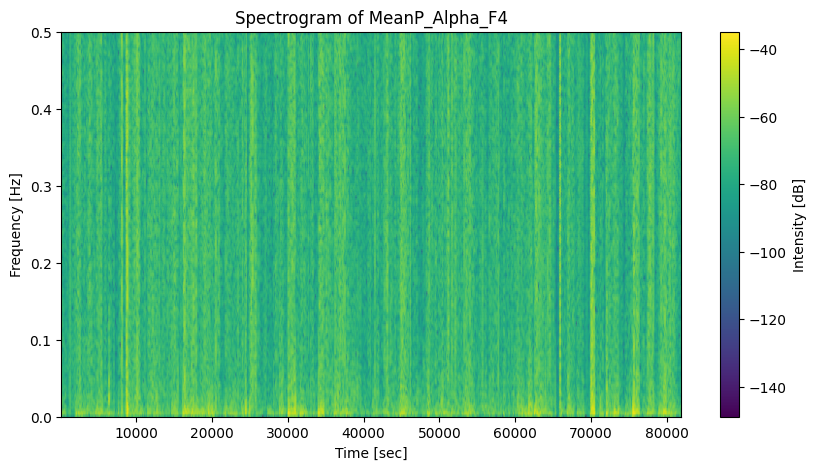

In [8]:
signal_data = cleaned_data['MeanP_Alpha_F4']

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(signal_data, fs=1, nperseg=256, noverlap=128)

# Plot the spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of MeanP_Alpha_F4')
plt.colorbar(label='Intensity [dB]')
plt.show()

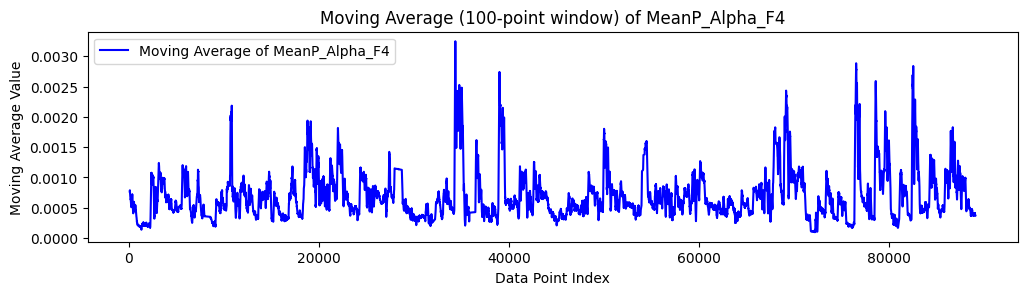

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot( cleaned_data['MeanP_Alpha_F4'].rolling(window=100).mean(), label='Moving Average of MeanP_Alpha_F4', color='blue')
plt.title('Moving Average (100-point window) of MeanP_Alpha_F4')
plt.xlabel('Data Point Index')
plt.ylabel('Moving Average Value')
plt.legend()

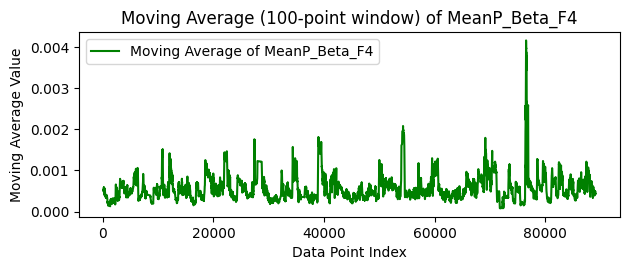

In [10]:
plt.subplot(2, 1, 2)
plt.plot(cleaned_data['MeanP_Beta_F4'].rolling(window=100).mean(), label='Moving Average of MeanP_Beta_F4', color='green')
plt.title('Moving Average (100-point window) of MeanP_Beta_F4')
plt.xlabel('Data Point Index')
plt.ylabel('Moving Average Value')
plt.legend()

plt.tight_layout()
plt.show()

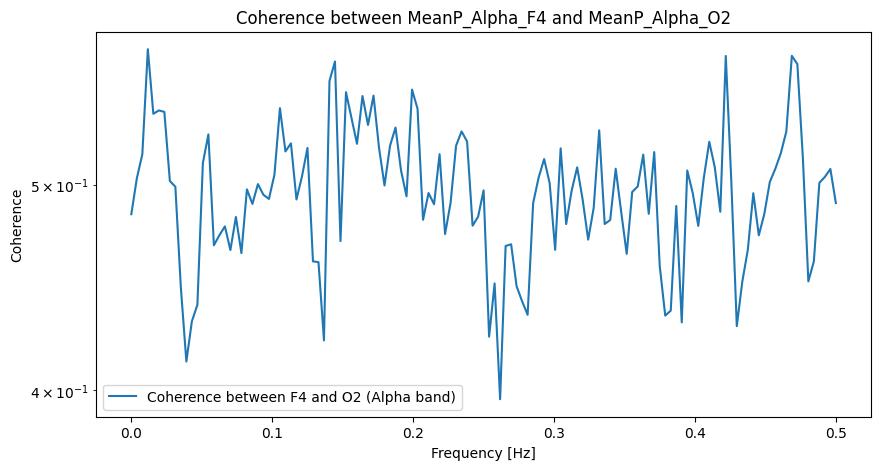

In [11]:
from scipy.signal import coherence

alpha_f4 = cleaned_data['MeanP_Alpha_F4'].values
alpha_o2 = cleaned_data['MeanP_Alpha_O2'].values

frequencies, coh = coherence(alpha_f4, alpha_o2, fs=1, nperseg=256)

# Plot coherence
plt.figure(figsize=(10, 5))
plt.semilogy(frequencies, coh, label='Coherence between F4 and O2 (Alpha band)')
plt.title('Coherence between MeanP_Alpha_F4 and MeanP_Alpha_O2')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.legend()
plt.show()

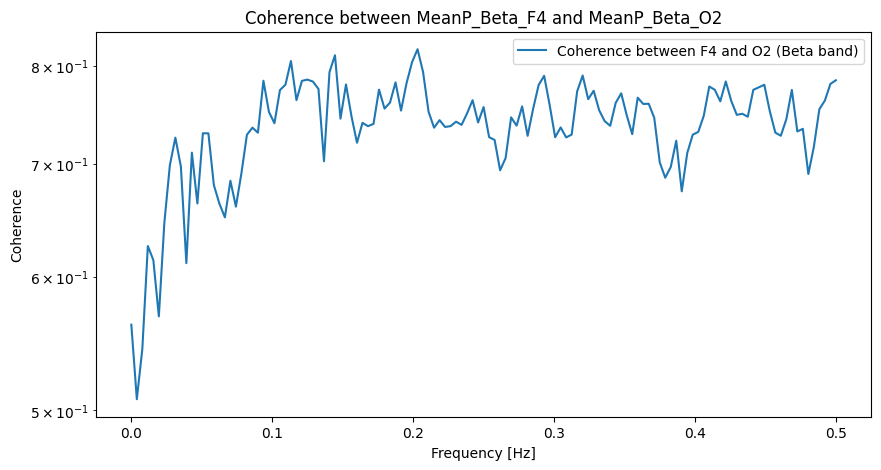

In [12]:
beta_f4 = cleaned_data['MeanP_Beta_F4'].values
beta_o2 = cleaned_data['MeanP_Beta_O2'].values

beta_frequencies, beta_coh = coherence(beta_f4, beta_o2, fs=1, nperseg=256)

plt.figure(figsize=(10, 5))
plt.semilogy(beta_frequencies, beta_coh, label='Coherence between F4 and O2 (Beta band)')
plt.title('Coherence between MeanP_Beta_F4 and MeanP_Beta_O2')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.legend()
plt.show()

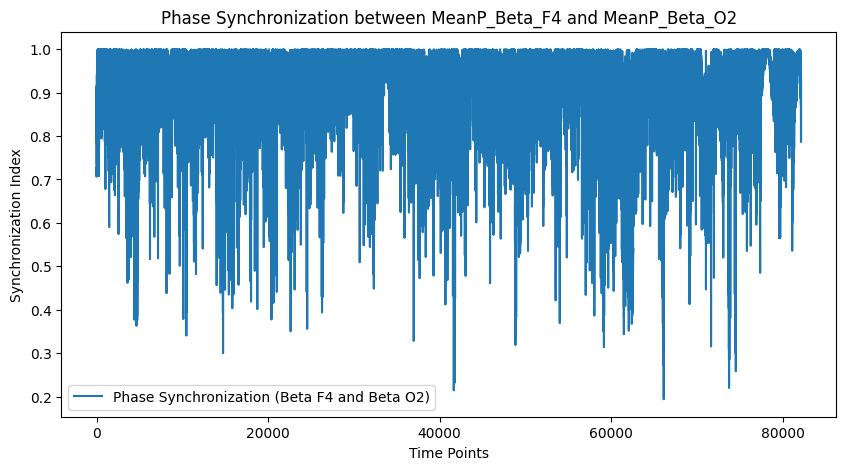

In [13]:
def phase_synchronization(signal1, signal2):
    analytic_signal1 = hilbert(signal1)
    analytic_signal2 = hilbert(signal2)

    phase1 = np.angle(analytic_signal1)
    phase2 = np.angle(analytic_signal2)

    # phase difference
    phase_diff = np.abs(phase1 - phase2)

    # Calculate the phase synchronization index
    sync_index = 1 - phase_diff / np.pi

    return sync_index

phase_sync = phase_synchronization(beta_f4, beta_o2)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(phase_sync, label='Phase Synchronization (Beta F4 and Beta O2)')
plt.title('Phase Synchronization between MeanP_Beta_F4 and MeanP_Beta_O2')
plt.xlabel('Time Points')
plt.ylabel('Synchronization Index')
plt.legend()
plt.show()

In [14]:
X = cleaned_data.drop('Sleep_Stage', axis=1)
y = cleaned_data['Sleep_Stage'].apply(lambda x: 1 if x == 'REM' else 0)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [16]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_train_scaled.shape,X_val_scaled.shape

((65730, 75, 1), (16433, 75, 1))

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, input_shape=(X_train_scaled.shape[1], 1), return_sequences=True, kernel_initializer=GlorotUniform(seed=42)),
    Dropout(0.5),
    LSTM(32, kernel_initializer=GlorotUniform(seed=42)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Use an Adam optimizer
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 75, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history=model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=5, batch_size=64)

Epoch 1/5
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 98s 90ms/step - accuracy: 0.7795 - loss: 0.5277 - val_accuracy: 0.8161 - val_loss: 0.4496
Epoch 2/5
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 92s 89ms/step - accuracy: 0.8170 - loss: 0.4525 - val_accuracy: 0.8172 - val_loss: 0.4438
Epoch 3/5
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 156s 103ms/step - accuracy: 0.8184 - loss: 0.4470 - val_accuracy: 0.8184 - val_loss: 0.4412
Epoch 4/5
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 132s 93ms/step - accuracy: 0.8177 - loss: 0.4476 - val_accuracy: 0.8187 - val_loss: 0.4385
Epoch 5/5
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 141s 93ms/step - accuracy: 0.8201 - loss: 0.4417 - val_accuracy: 0.8181 - val_loss: 0.4388


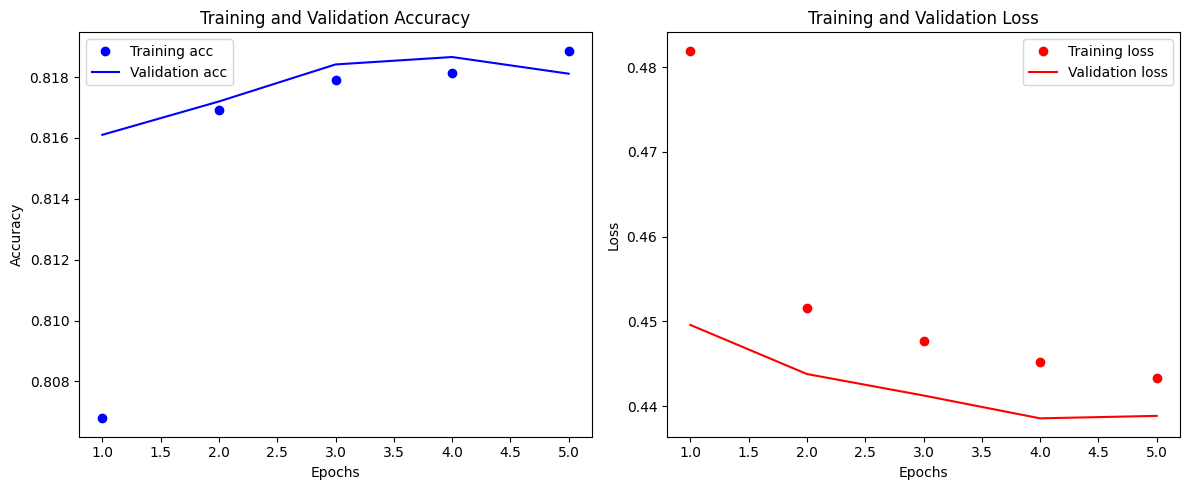

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
!pip install gradio
import gradio as gr
import numpy as np
import pandas as pd # Ensure pandas is available if not explicitly imported earlier

# The 'model', 'scaler', and 'X' (DataFrame of features) are available from previous cells.

def predict_sleep_stage(feature_values_str):
    try:
        # Parse the input string into a list of floats
        features = [float(f.strip()) for f in feature_values_str.split(',')]

        # Check if the number of features is correct (should be 75 based on X_train_scaled.shape[1])
        if len(features) != X.shape[1]:
            return f"Error: Expected {X.shape[1]} features, but got {len(features)}. Please provide all feature values."

        # Convert to numpy array and reshape for scaling (scaler expects 2D input: [samples, features])
        input_data = np.array(features).reshape(1, -1)

        # Scale the input data using the pre-fitted scaler
        scaled_input = scaler.transform(input_data)

        # Reshape for the LSTM model (add a time step dimension: [batch_size, timesteps, features])
        # Here, timesteps is the number of features (75) and features per timestep is 1.
        reshaped_input = scaled_input.reshape(1, scaled_input.shape[1], 1)

        # Make prediction using the trained model
        prediction_probability = model.predict(reshaped_input)[0][0]

        # Interpret the prediction
        if prediction_probability >= 0.5:
            return f"Predicted Sleep Stage: REM (Probability: {prediction_probability:.4f})"
        else:
            return f"Predicted Sleep Stage: NREM (Probability: {prediction_probability:.4f})"

    except ValueError:
        return "Error: Invalid input. Please enter comma-separated numerical values."
    except Exception as e:
        return f"An unexpected error occurred: {e}"

# Get feature names for potential input labels or examples
feature_names = X.columns.tolist()

# Create an example input string from the first row of your feature data
example_input = ", ".join(map(str, X.iloc[0].values))

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_sleep_stage,
    inputs=gr.Textbox(
        label=f"Enter {X.shape[1]} comma-separated feature values (e.g., {feature_names[0]}, {feature_names[1]}, ...)",
        placeholder=example_input, # Provide an example in the textbox
        lines=5 # Allow multi-line input for easier viewing of many features
    ),
    outputs=gr.Label(label="Prediction Result"),
    title="Sleep Stage Classification Model",
    description="This interface predicts the sleep stage (REM or NREM) based on 75 input features. The model is an LSTM neural network." # More descriptive text
)

# Launch the interface
iface.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://57dab29d176f29cd21.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://57dab29d176f29cd21.gradio.live


In [21]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Reshape X_train_scaled from 3D to 2D for RandomForestClassifier
X_train_2d = X_train_scaled.reshape(X_train_scaled.shape[0], -1)

# Fit the model
rf_classifier.fit(X_train_2d, y_train)

# Extract feature importances
feature_importances = rf_classifier.feature_importances_

# Create a pandas Series for better visualization
feature_importance_series = pd.Series(feature_importances, index=X.columns)

# Sort the features by importance in descending order
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

# Display the top features
print("Top 10 Most Important Features:")
print(sorted_feature_importances.head(10))

Top 10 Most Important Features:
MeanP_Delta_C4            0.040744
MedianF_Beta_F4           0.036111
MeanF_Alpha_F4            0.034794
MeanP_Delta_O2            0.026187
MeanP_Delta_F4            0.023634
MeanP_Theta_O2            0.022205
MeanP_Theta_F4            0.020618
MeanP_Beta_C4             0.020234
MeanP_Alpha_C4            0.018368
Spectral Edge_Theta_F4    0.018261
dtype: float64


## Select Top 10 Features



In [22]:
top_10_features = sorted_feature_importances.head(10).index.tolist()
X_10_features = X[top_10_features]

print("Shape of X_10_features:", X_10_features.shape)
print("Columns in X_10_features:", X_10_features.columns.tolist())

Shape of X_10_features: (82163, 10)
Columns in X_10_features: ['MeanP_Delta_C4', 'MedianF_Beta_F4', 'MeanF_Alpha_F4', 'MeanP_Delta_O2', 'MeanP_Delta_F4', 'MeanP_Theta_O2', 'MeanP_Theta_F4', 'MeanP_Beta_C4', 'MeanP_Alpha_C4', 'Spectral Edge_Theta_F4']


In [23]:
X_train_10, X_val_10, y_train_10, y_val_10 = train_test_split(X_10_features, y, test_size=0.20, random_state=42, stratify=y)

print(f"Shape of X_train_10: {X_train_10.shape}")
print(f"Shape of X_val_10: {X_val_10.shape}")
print(f"Shape of y_train_10: {y_train_10.shape}")
print(f"Shape of y_val_10: {y_val_10.shape}")

Shape of X_train_10: (65730, 10)
Shape of X_val_10: (16433, 10)
Shape of y_train_10: (65730,)
Shape of y_val_10: (16433,)


In [24]:
scaler_10_features = StandardScaler()
X_train_10_scaled = scaler_10_features.fit_transform(X_train_10)
X_val_10_scaled = scaler_10_features.transform(X_val_10)

print(f"Shape of X_train_10_scaled: {X_train_10_scaled.shape}")
print(f"Shape of X_val_10_scaled: {X_val_10_scaled.shape}")

Shape of X_train_10_scaled: (65730, 10)
Shape of X_val_10_scaled: (16433, 10)


In [25]:
X_train_10_scaled = X_train_10_scaled.reshape(X_train_10_scaled.shape[0], X_train_10_scaled.shape[1], 1)
X_val_10_scaled = X_val_10_scaled.reshape(X_val_10_scaled.shape[0], X_val_10_scaled.shape[1], 1)

print(f"Reshaped X_train_10_scaled shape: {X_train_10_scaled.shape}")
print(f"Reshaped X_val_10_scaled shape: {X_val_10_scaled.shape}")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam

model_10_features = Sequential([
    LSTM(64, input_shape=(X_train_10_scaled.shape[1], 1), return_sequences=True, kernel_initializer=GlorotUniform(seed=42)),
    Dropout(0.5),
    LSTM(32, kernel_initializer=GlorotUniform(seed=42)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer_10_features = Adam(learning_rate=0.0001)

model_10_features.compile(optimizer=optimizer_10_features, loss='binary_crossentropy', metrics=['accuracy'])

model_10_features.summary()

Reshaped X_train_10_scaled shape: (65730, 10, 1)
Reshaped X_val_10_scaled shape: (16433, 10, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_10_features = model_10_features.fit(X_train_10_scaled, y_train_10, validation_data=(X_val_10_scaled, y_val_10), epochs=5, batch_size=64)

Epoch 1/5
 481/1028 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.7688 - loss: 0.6064

## Create Gradio Interface for 10-Feature Model



In [ ]:
def predict_sleep_stage_10_features(*feature_values):
    try:
        # Convert input tuple to numpy array and reshape for scaler (1 sample, 10 features)
        input_data = np.array(feature_values).reshape(1, -1)

        # Scale the input data using the pre-fitted scaler for 10 features
        scaled_input = scaler_10_features.transform(input_data)

        # Reshape for the LSTM model (1 sample, 10 timesteps, 1 feature per timestep)
        reshaped_input = scaled_input.reshape(1, scaled_input.shape[1], 1)

        # Make prediction using the trained model
        prediction_probability = model_10_features.predict(reshaped_input)[0][0]

        # Interpret the prediction
        if prediction_probability >= 0.5:
            return f"Predicted Sleep Stage: REM (Probability: {prediction_probability:.4f})"
        else:
            return f"Predicted Sleep Stage: NREM (Probability: {prediction_probability:.4f})"

    except ValueError:
        return "Error: Invalid input. Please enter numerical values."
    except Exception as e:
        return f"An unexpected error occurred: {e}"

# Get feature names and example values for the Gradio interface inputs
feature_names_10 = X_10_features.columns.tolist()
example_values_10 = X_10_features.iloc[0].values

# Create a list of gr.Number input components
gradio_inputs_10 = []
for i, feature_name in enumerate(feature_names_10):
    gr.Number(label=feature_name, value=example_values_10[i])
    gradio_inputs_10.append(gr.Number(label=feature_name, value=example_values_10[i]))

# Create the Gradio interface for the 10-feature model
iface_10_features = gr.Interface(
    fn=predict_sleep_stage_10_features,
    inputs=gradio_inputs_10,
    outputs=gr.Label(label="Prediction Result"),
    title="Sleep Stage Classification Model (Top 10 Features)",
    description="This interface predicts the sleep stage (REM or NREM) based on the top 10 most important features. Please enter numerical values for each feature."
)

# Launch the interface
iface_10_features.launch(debug=True, share=True)